In [1]:
import pandas as pd
import re
import seaborn as sns
import numpy as np

#df = pd.read_csv("NBA.csv")
#print(df.head())
#print(df.describe().T)

TS_RATIO = .44
EFG_RATIO = .5

class NBA_Player():
    

    def __init__(self, gamesPlayed, name, team, pts, reb, ast, college, height, weight, birthdate, fga, threePA, threePM, fta, ftm, fgm):
        self._gamesPlayed = gamesPlayed
        self._name = name
        self._team = team
        self._pts = pts
        self._reb = reb
        self._ast = ast
        self._college = college
        self._height = height
        self._weight = weight
        self._birthdate = birthdate
        self._fga = fga
        self._threePA = threePA
        self._threePM = threePM
        self._fta = fta
        self._ftm = ftm
        self._fgm = fgm
        self._ts = self.calcTrueShooting()
        self._efg = self.calcEffectiveFieldGoal()
        self._efg_ts_diff = self._efg - self._ts

    def calcTrueShooting(self):
        denom = 2 * (self._fga + (TS_RATIO * self._fta))
        if denom == 0:
            return 0
        tmp_ts = self._pts / denom
        self._ts = tmp_ts
        return tmp_ts
    
    def calcEffectiveFieldGoal(self):
        if self._fga == 0:
            return 0
        return (self._fgm + (EFG_RATIO * self._threePM)) / self._fga
    
    @property
    def true_shooting(self):
        return self._ts
    @property
    def effective_field_goal(self):
        return self._efg
    @property
    def stat_diff(self):
        return self._efg_ts_diff
    @property
    def college(self):
        return self._college
    @property
    def name(self):
        return self._name
    
    def __lt__(self, other):
        return self._efg_ts_diff < other._efg_ts_diff
    
    def collegeBase(self):
        stopwords = ["University", "College", "of", "at", "the", "College"]
        
        if (len(str(self._college)) == 0) or (type(self._college) in [float, int]):
            return "No College"
        college = self._college.split(" ")
        college = [word for word in college if word not in stopwords]

        college = " ".join(college)
        return college
    def __str__(self):
        return f"{self._name} ({self._team}) - {self.true_shooting} TS, {self.effective_field_goal} EFG"
    
    def asDataframe(self):
        return pd.DataFrame({
            "Name": [self._name],
            "Team": [self._team],
            "Points": [self._pts],
            "Games": [self._gamesPlayed],
            "Rebounds": [self._reb],
            "True Shooting": [self._ts],
            "Effective Field Goal": [self._efg],
            "College": [self._college],
            "Height": [self._height],
            "Difference": [self._efg_ts_diff]})
    @staticmethod
    def readCSV(filepath):
        try:
            player_data = pd.read_csv(filepath)
        except FileNotFoundError:
            print("File not found")
            return None
        all_players = []
        for index, row in player_data.iterrows():
            player = NBA_Player(row["Games Played"], row["Name"], row["Team"], row["PTS"],
                                row["REB"], row["AST"], row["Collage"], row["Height"],
                                row["Weight"], row["Birthdate"], row["FGA"], row["3PA"],
                                row["3PM"], row["FTA"], row["FTM"], row["FGM"])
            all_players.append(player)
        return all_players
        
    @staticmethod
    def createDFfromPlayers(players):
        return pd.concat([player.asDataframe() for player in players], ignore_index=True)
    
    @staticmethod
    def contest(player1, player2, metric="TS", rounds=100, tests=1000, debug_print=False):
        if metric == "TS":
            p1percent = player1.true_shooting
            p2percent = player2.true_shooting
        elif metric == "EFG":
            p1percent = player1.effective_field_goal
            p2percent = player2.effective_field_goal
        else:
            raise ValueError("Invalid metric")
        
        p1wins = 0
        p2wins = 0
        ties = 0
        p1_vals = np.random.binomial(rounds, p1percent, tests)
        p2_vals = np.random.binomial(rounds, p2percent, tests)
        for i in range(tests):
            pts_p1 = p1_vals[i]
            pts_p2 = p2_vals[i]
            
            if debug_print:
                print(f"Round {i}: {player1._name} scored {pts_p1} and {player2._name} scored {pts_p2}")
            
            if pts_p1 > pts_p2:
                p1wins += 1
            elif pts_p2 > pts_p1:
                p2wins += 1
            else:
                ties += 1
        return p1wins, p2wins, ties


In [2]:
all_players = NBA_Player.readCSV("NBA.csv")

filt_df = NBA_Player.createDFfromPlayers(all_players)

In [3]:
print(len(all_players))

490


In [4]:
p3 = NBA_Player(name="Michael Jordan", team="CHI", pts=3000, reb=500, ast=400, college="University of North Carolina",
            height="6-6", weight=220, birthdate="02/17/1963", fga=2000, threePA=100,
            threePM=45, fta=400, ftm=300, fgm=1500, gamesPlayed=82)
print(p3.collegeBase())

North Carolina


In [14]:
p2 = NBA_Player(name="Kevin Durant", team="GSW", pts=2020, reb=300, ast=200, college="Texas",
            height="6-11", weight=240, birthdate="09/29/1988", fga=1000, threePA=300,
            threePM=145, fta=240, ftm=200, fgm=800, gamesPlayed=70)
print(p2.true_shooting)
print(p2.effective_field_goal)
print(p2.stat_diff)

0.9135311143270624
0.8725
-0.0410311143270623


In [6]:
p1 = NBA_Player(name="Lebron James", team="LAL", pts=2779, reb=456, ast=353, college="No College", 
                height="6-9", weight=250, birthdate="12/30/1984", fga=1500, threePA=500, 
                threePM=245, fta=340, ftm=274, fgm=1235, gamesPlayed=82)
print(p1.true_shooting)
print(p1.effective_field_goal)
print(p1.stat_diff)

0.8423254122211445
0.905
0.06267458777885548


In [7]:
test_contests = 3

for i in range(test_contests):
    p1 = all_players[np.random.randint(0, len(all_players))]
    p2 = all_players[np.random.randint(0, len(all_players))]
    p1wins, p2wins, ties = NBA_Player.contest(p1, p2, metric="TS", rounds=1000)
    print(f"{p1._name} vs {p2._name} - {p1wins} to {p2wins} with {ties} ties")

John Lucas III vs Markel Brown - 520 to 464 with 16 ties
Zoran Dragic vs LeBron James - 0 to 1000 with 0 ties
KJ McDaniels vs Gerald Green - 50 to 945 with 5 ties


In [8]:
p1 = [x for x in all_players if x.name == "Chris Paul"][0]
p2 = [x for x in all_players if x.name == "Damian Lillard"][0]

p1wins, p2wins, ties = NBA_Player.contest(p1, p2, metric="EFG", rounds=1000)
print(f"{p1._name} vs {p2._name} - {p1wins} to {p2wins} with {ties} ties")

Chris Paul vs Damian Lillard - 971 to 29 with 0 ties


In [9]:
filt_df.head()

,Name,Team,Points,Games,Rebounds,True Shooting,Effective Field Goal,College,Height,Difference
0,AJ Price,PHO,133,26,32,0.450664,0.427007,University of Connecticut,185.0,-0.023657
1,Aaron Brooks,CHI,954,82,166,0.533820,0.495104,University of Oregon,180.0,-0.038716
2,Aaron Gordon,ORL,243,47,169,0.517374,0.478365,University of Arizona,202.5,-0.039008
3,Adreian Payne,ATL,213,32,162,0.443307,0.415909,Michigan State University,205.0,-0.027398
4,Al Horford,ATL,1156,76,544,0.562782,0.543523,University of Florida,205.0,-0.019259


<Axes: xlabel='Difference', ylabel='Count'>

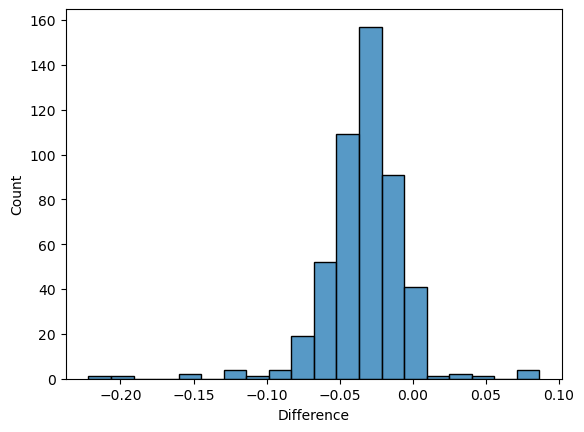

In [10]:
sns.histplot(filt_df["Difference"], bins=20)

<Axes: xlabel='True Shooting', ylabel='Effective Field Goal'>

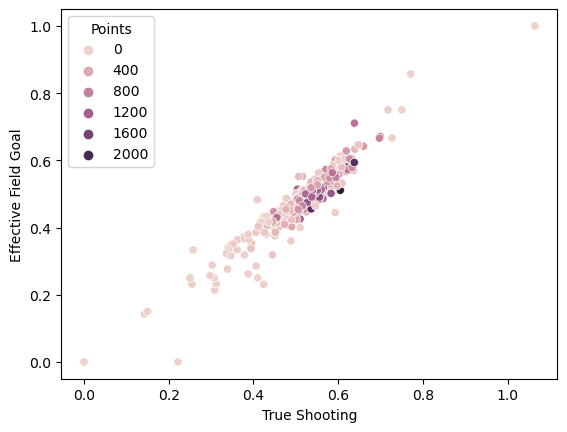

In [11]:
sns.scatterplot(data=filt_df, x="True Shooting", y="Effective Field Goal", hue="Points")

In [12]:
df_pos = filt_df[filt_df["Difference"] > 0]
print(len(df_pos))
df_pos.head(20)

18


,Name,Team,Points,Games,Rebounds,True Shooting,Effective Field Goal,College,Height,Difference
19,Andre Drummond,DET,1130,82,1104,0.503745,0.514048,University of Connecticut,207.5,0.010303
33,Arinze Onuaku,MIN,27,6,21,0.770548,0.857143,Syracuse University,202.5,0.086595
82,Clint Capela,HOU,32,12,36,0.408998,0.482759,NaN,205.0,0.073761
106,DeAndre Jordan,LAC,946,82,1226,0.638120,0.710674,Texas A&M University,207.5,0.072554
117,Devyn Marble,ORL,37,16,31,0.362461,0.363636,University of Iowa,195.0,0.001176
133,Earl Clark,NJN,27,10,23,0.425063,0.433333,University of Louisville,205.0,0.008270
134,Ed Davis,LAL,656,79,600,0.594031,0.601279,University of North Carolina,205.0,0.007249
138,Elliot Williams,NaN,37,13,8,0.477296,0.486486,NaN,NaN,0.009190
149,Francisco Garcia,HOU,45,14,17,0.347437,0.349206,University of Louisville,197.5,0.001770
169,Greg Smith,DAL,80,42,79,0.604595,0.612245,"California State University, Fresno",205.0,0.007650
